In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from datetime import datetime, timedelta
from scipy import stats

rng = default_rng()

In [2]:
def hawkes_process(mu , alpha , beta , T):
    """
    Simulate a Hawkes process using Ogata's thinning method.

    Parameters:
    mu : float
        Baseline intensity.
    alpha : float
        Excitation parameter.
    beta : float
        Decay parameter.
    T : float
        Time horizon for the simulation.

    Returns:
    events : list
        List of event times.
    lambda_bar: upper bound on intensity (starts at baseline)
    excitation_term: sum of past event contributions (initially zero)
    """
    if (alpha >= beta):
        raise ValueError("The process is unstable: alpha must be less than beta.")
    if mu <= 0 or alpha <= 0 or beta <= 0:
        raise ValueError("All parameters (μ, α, β) must be positive")
    
    if T <= 0:
        raise ValueError("Time horizon T must be positive")
    
    events = []
    times = []
    lambdas = []
    t = 0
    lambda_bar = mu
    excitation_term=0
    while t<T:
        delta_t=rng.exponential(1/lambda_bar)
        t += delta_t
        uniform_prob=rng.uniform(0,1)
        # O(1) version
        excitation_term = excitation_term * np.exp(-beta * delta_t)
        lambda_t = mu + excitation_term
        # lambda_t = mu + sum(alpha * np.exp(-beta * (t - np.array(events)))) --- O(n^2) version
        if uniform_prob <= lambda_t / lambda_bar:
            events.append(t)
            excitation_term += alpha
        lambda_bar = lambda_t + alpha  # update upper bound
        times.append(t)
        lambdas.append(lambda_t)
    
    return events , times , lambdas
            
    


In [3]:
if __name__ == "__main__":
    mu = 0.5
    alpha = 0.8
    beta = 1.2
    T = 10000

    events , times, lambdas = hawkes_process(mu, alpha, beta, T)

    print("length of events \n" ,len(events), "\n" ,"length of times \n" , len(times), "\n" , "length of lambdas \n", len(lambdas))
    print("EVENTS \n",events[:10] ,"\n", "TIMES \n", times[:10] , "\n" , "LAMBDAS \n", lambdas[:10])
    # print("EVENTS \n",events[:-10] ,"\n", "TIMES \n", times[:-10] , "\n" , "LAMBDAS \n", lambdas[:-10])

length of events 
 15259 
 length of times 
 22748 
 length of lambdas 
 22748
EVENTS 
 [1.8218370102141697, 2.4849346725630945, 2.8746430414951334, 3.004286555381107, 3.0372382461848453, 3.075317658493466, 3.1782251495050993, 3.3367015132543125, 3.474301284986275, 3.607055061584971] 
 TIMES 
 [1.8218370102141697, 2.048995933941307, 2.4849346725630945, 2.8746430414951334, 3.004286555381107, 3.0372382461848453, 3.075317658493466, 3.1782251495050993, 3.3367015132543125, 3.474301284986275] 
 LAMBDAS 
 [0.5, 1.1091234881729308, 0.8610059834499839, 1.2273385810222233, 1.8072876760872278, 2.525587192316097, 3.1993767253960916, 3.5928589353914084, 3.7186827629215173, 3.907007881295664]


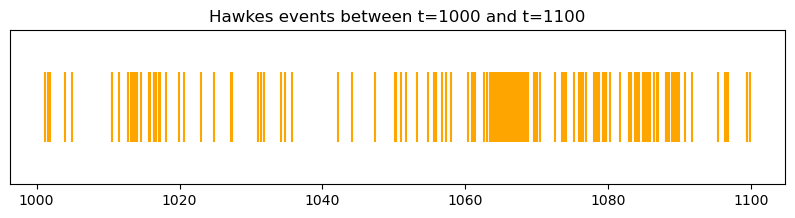

In [4]:
# zoom into a short interval
t0, t1 = 1000, 1100
zoomed = [t for t in events if t0 <= t <= t1]

plt.figure(figsize=(10, 2))
plt.eventplot(zoomed, orientation='horizontal', colors='orange')
plt.title(f'Hawkes events between t={t0} and t={t1}')
plt.yticks([])
plt.show()


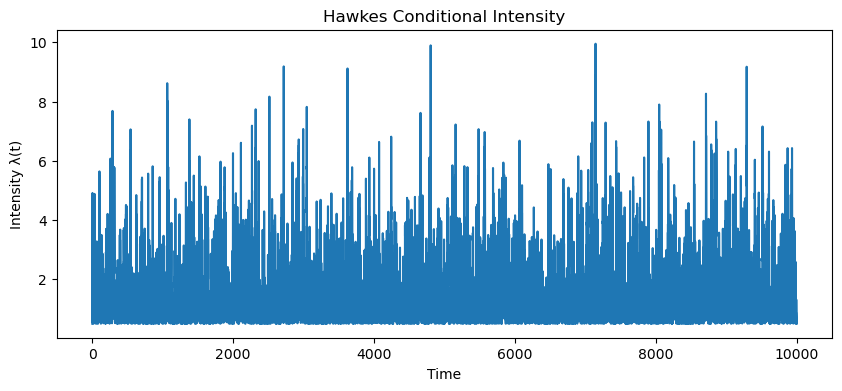

In [5]:
plt.figure(figsize=(10,4))
plt.plot(times, lambdas)
plt.xlabel("Time")
plt.ylabel("Intensity λ(t)")
plt.title("Hawkes Conditional Intensity")
plt.show()

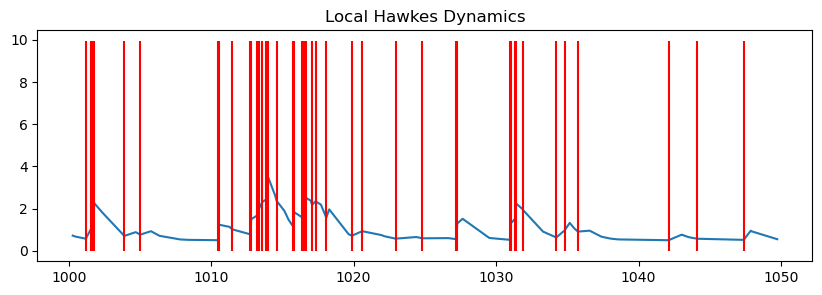

In [6]:
t0, t1 = 1000, 1050
mask = [(t0 <= t <= t1) for t in times]

plt.figure(figsize=(10,3))
plt.plot(
    [t for t, m in zip(times, mask) if m],
    [l for l, m in zip(lambdas, mask) if m]
)
plt.vlines(
    [t for t in events if t0 <= t <= t1],
    ymin=0, ymax=max(lambdas),
    color='red'
)
plt.title("Local Hawkes Dynamics")
plt.show()


In [7]:
# hawkes process validation
# KS test on time-rescaled inter-arrival times using the conditional intensity
import numpy as np

def time_rescaling(events, mu, alpha, beta):
    """
    Compute time-rescaled inter-arrival times τ using integrated intensity.

    Parameters
    ----------
    events : array-like
        Accepted Hawkes event times (sorted)
    times : array-like
        Times at which λ(t) was evaluated
    lambdas : array-like
        Corresponding intensity values λ(t)

    Returns
    -------
    taus : np.ndarray
        Time-rescaled inter-arrival times τ
    """

    events = np.asarray(events)
    taus = []

    for i in range(1, len(events)):
        t_prev = events[i-1]
        t_curr = events[i]

        # baseline contribution
        tau = mu * (t_curr - t_prev)

        # excitation contribution
        for tj in events[:i-1]:
            tau += (alpha / beta) * (
                np.exp(-beta * (t_prev - tj)) -
                np.exp(-beta * (t_curr - tj))
            )

        taus.append(tau)

    return np.array(taus)


def ks_test_hawkes(taus, alpha=0.05, make_plots=True):
    """
    Kolmogorov–Smirnov test for Hawkes time-rescaled inter-arrival times.
    Tests H0: tau ~ Exp(1)

    Parameters
    ----------
    taus : array-like
        Time-rescaled inter-arrival times
    alpha : float
        Significance level (default 0.05)
    make_plots : bool
        Whether to show histogram, CDF, and QQ plot

    Returns
    -------
    ks_stat : float
    p_value : float
    """

    taus = np.asarray(taus)
    taus = taus[taus > 0]   # safety cleanup

    # ---- KS TEST ----
    ks_stat, p_value = stats.kstest(taus, 'expon')

    print("KOLMOGOROV–SMIRNOV TEST (τ ~ Exp(1))")
    print("----------------------------------")
    print(f"KS statistic : {ks_stat:.4f}")
    print(f"p-value      : {p_value:.4f}")

    if p_value > alpha:
        print(" FAIL TO REJECT H0 → Hawkes model is consistent")
    else:
        print(" REJECT H0 → Hawkes model is misspecified")

    # ---- PLOTS ----
    if make_plots:
        # Histogram
        plt.figure(figsize=(6,4))
        plt.hist(taus, bins=50, density=True, alpha=0.6, label="Empirical τ")
        x = np.linspace(0, np.max(taus), 300)
        plt.plot(x, stats.expon.pdf(x), 'r--', label="Exp(1)")
        plt.xlabel("τ")
        plt.ylabel("Density")
        plt.title("Time-Rescaled Inter-Arrival Times")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        # Empirical vs theoretical CDF
        sorted_tau = np.sort(taus)
        emp_cdf = np.arange(1, len(sorted_tau)+1) / len(sorted_tau)
        theo_cdf = 1 - np.exp(-sorted_tau)

        plt.figure(figsize=(6,4))
        plt.plot(sorted_tau, emp_cdf, label="Empirical CDF")
        plt.plot(sorted_tau, theo_cdf, 'r--', label="Exp(1) CDF")
        plt.xlabel("τ")
        plt.ylabel("CDF")
        plt.title("KS Test: Empirical vs Theoretical CDF")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        # QQ plot
        plt.figure(figsize=(5,5))
        stats.probplot(taus, dist="expon", plot=plt)
        plt.title("QQ Plot: τ vs Exp(1)")
        plt.grid(alpha=0.3)
        plt.show()

    return ks_stat, p_value


Mean tau: 0.7528289102471247
KOLMOGOROV–SMIRNOV TEST (τ ~ Exp(1))
----------------------------------
KS statistic : 0.1235
p-value      : 0.0000
 REJECT H0 → Hawkes model is misspecified


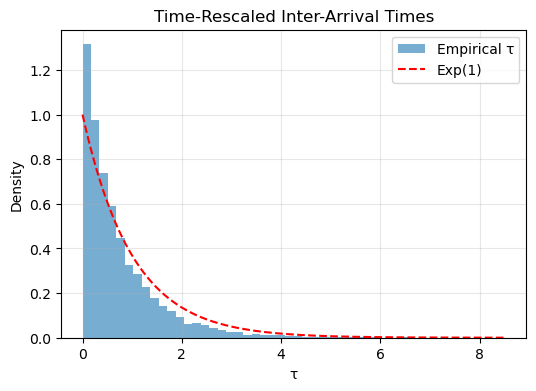

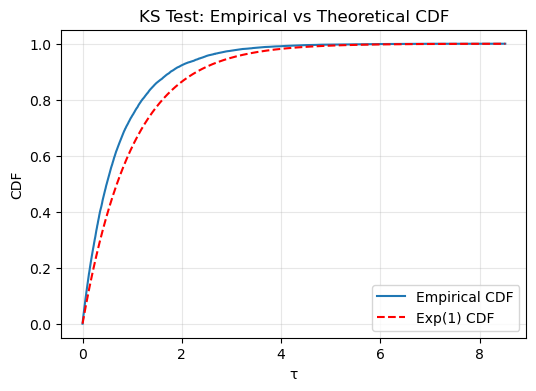

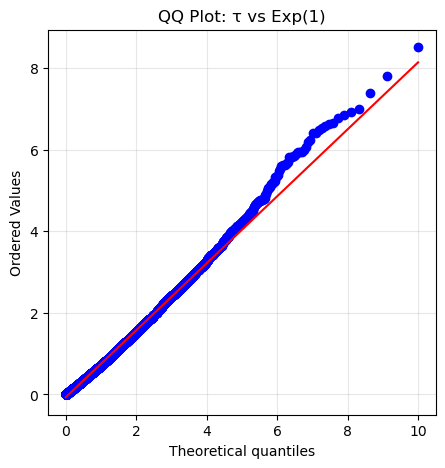

In [8]:
taus = time_rescaling(events, mu, alpha, beta)
print("Mean tau:", np.mean(taus))

ks_stat, p_value = ks_test_hawkes(taus)

In [9]:
# AUTOCORRELATION

def time_series(events , T , bin_width=1):

    bin_size=int(T/bin_width)
    counts = np.zeros(bin_size)
    for t in events:
        bin_index=int(t/bin_width)
        if bin_index < bin_size:
            counts[bin_index] += 1

    return counts

counts = time_series(events , 10000 , bin_width=1)
print("Counts per bin: \n", counts)

from statsmodels.tsa.stattools import acf
acf_values = acf(counts, nlags=40)

print("Autocorrelation values: \n", acf_values)


Counts per bin: 
 [0. 1. 2. ... 0. 0. 0.]
Autocorrelation values: 
 [ 1.00000000e+00  4.39982811e-01  3.04579072e-01  2.01157765e-01
  1.35628895e-01  8.38746643e-02  5.20681496e-02  3.13309706e-02
  6.36183625e-03  1.30254218e-02  6.69323070e-03  7.91396707e-03
  1.28333083e-02  1.55881730e-02  1.23300010e-02  1.34111402e-02
 -2.70465201e-03 -9.07944262e-03  7.99809226e-03  1.28071964e-02
  9.25226870e-03  8.61564233e-03  9.33238823e-03  9.95357708e-03
  4.16797589e-03  3.70030677e-03  1.10089206e-02  1.55407471e-03
  3.39191994e-03  1.42080245e-02  9.77435498e-03  1.55473999e-02
 -6.66806850e-03 -1.42229522e-02 -1.86390604e-02 -1.08543755e-02
 -7.88795412e-03 -1.00279081e-02 -4.44597724e-03 -7.55091172e-04
  3.75869791e-03]


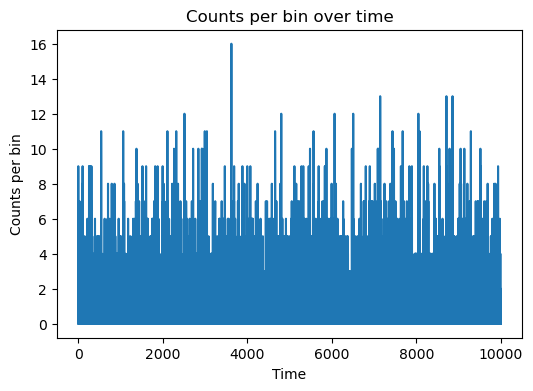

In [10]:
time_axis = np.arange(len(counts))
plt.figure(figsize=(6,4))
plt.plot(time_axis, counts)
plt.xlabel("Time")
plt.ylabel("Counts per bin")
plt.title("Counts per bin over time")
plt.show()

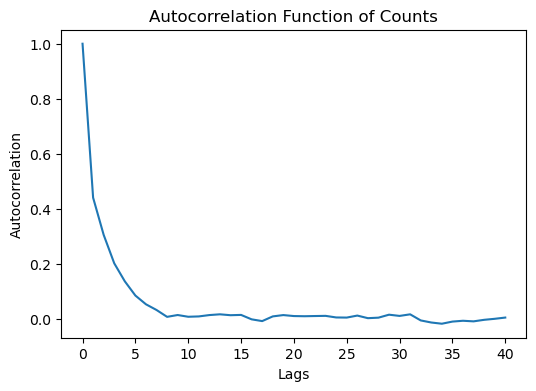

In [11]:
plt.figure(figsize=(6,4))
plt.plot(acf_values)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function of Counts")
plt.show()